# Árboles de Decisión para la Clasificación de SPAM

Este script tiene como objetivo aplicar un modelo de Árboles de Decisión para la clasificación de correos SPAM y HAM.

Se realiza un análisis cuando se entrega una semilla y cuando no se hace, así como si se debe o no estandarizar los datos.

Todo el modelo será evaluado usando accuracy,F1-score, Z-score, precision-score, recall-score y ROC-AUC-score.

@authors: Duvan Santiago Matallana Jiménez - Laura Estefania Latorre Pachon   Grupo: 802  
@date: 2025-09-10   

Universidad de Cundinamarca  
Machine Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Importación de librerias**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, classification_report, roc_auc_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sns.set_style('whitegrid')
sns.set_palette('viridis')

###**Lectura y preprocesamiento de datos**

Lectura del archivo csv (cambiar la ruta) y se normalizan las dos columnas a una sola con true/false.

In [ ]:
def load_preprocess_data(path: str):
  """
    Loads the dataset and performs basic preprocessing.
    Args:
        path (str): Path to the CSV file containing the dataset.

    Returns:
        tuple: (X, y, ds) where X are the features, y is the target and ds is the original dataset.
  """
  try:
    ds = pd.read_csv(path, sep=';')
    print(f"Dataset has been upload correctly, columns: {ds.columns.tolist()}")

    if 'dominio_remitente' in ds.columns and 'dominio_respuesta' in ds.columns:
      ds['dominio_coincide'] = (ds['dominio_remitente'] == ds['dominio_respuesta']).astype(int)
      ds = ds.drop(columns=['dominio_remitente', 'dominio_respuesta'])
      print("✓ Feature 'dominio_coincide' created and original columns deleted")

    if 'clase' not in ds.columns:
      raise ValueError("The target column 'clase' is missing in the dataset")

    X = ds.drop('clase', axis=1)
    y = ds['clase']
    print("\nThe variables X and y have been created.\n")
    print(X.columns.tolist())
    return X, y, ds

  except FileNotFoundError:
    raise FileNotFoundError(f"Error: file not exist or wrong directory. Path: {path}")
  except Exception as e:
    raise Exception(f"Error loading dataset: {e}")


###**Definición de grupos de features**

Aquí se toman los grupos predefinidos en el clasificador líneal, y se crean en una lista para poder trabajarlos.

In [ ]:
def get_feature_groups():
  """
    Defines the 4 feature groups based on the original correlation analysis
    Args: None
    Returns:
        dict: A dictionary containing the feature groups.
  """
  groups = {
      'all': 'all',
      'high_correlation': [
          'cantidad_exclamaciones', 'cantidad_urls', 'javascript_embebido',
          'adjuntos_ejecutables', 'adjuntos_sospechosos', 'lenguaje_imperativo'
      ],
      'without_noise': [
          'cantidad_interrogaciones',
          'cantidad_dominios_urls',
          'dominio_coincide'
      ],
      'balanced': [
          'cantidad_urls',
          'lenguaje_imperativo',
          'adjuntos_sospechosos',
          'javascript_embebido',
          'adjuntos_ejecutables',
          'cantidad_exclamaciones',
          'cantidad_destinatarios',
          'ip_en_url',
          'idioma_diferente_usuario'
      ]
  }

  return groups

###**Selector de grupo**

Aquí se eliminan o toman las features necesarias según la petición del main.

In [ ]:
def select_features(X: pd.DataFrame, group_name: str):
  """
  Selects columns from a DataFrame based on a predefined feature group.
  - args:
      X (pd.DataFrame): The input DataFrame with all features.
      group_name (str): The name of the feature group to select.
  - returns:
      pd.DataFrame: A DataFrame containing only the selected features.
  """
  try:
    groups = get_feature_groups()
    features = groups.get(group_name)
    if features is None:
      raise ValueError(f"Invalid feature group: {group_name}")
    if group_name == 'all':
      return X
    elif group_name == 'without_noise':
      return X.drop(columns=features)
    else:
      available_features = [feat for feat in features if feat in X.columns]
      return X[available_features]

  except Exception as e:
    raise Exception(f"Error selecting features: {e}")

###**Prueba de normalización vs. No normalización**

En esta función se comparan los resultados de precisión según el F1_score, y se determina cual de los dos se usa.

Debido a que ambos tienen resultados similares, diferenciados por puntos decimales extremadamente bajos, se determina que es mejor no estandarizar, ahorrando recursos.

In [ ]:
def run_normalization_test(X_train, y_train, X_test, y_test):
  """
  Demonstrate the effect (or lack thereof) of feature scaling on a Decision Tree's
  performance.
  - args:
      X_train, y_train, X_test, y_test: The data splits.
  - returns:
      dict: A dictionary containing the F1 scores.
  """
  try:
    print("\nJustification for non-standardization: Does a Decision Tree need normalization?")

    model_unscaled = DecisionTreeClassifier(random_state=42)
    model_unscaled.fit(X_train, y_train)
    preds_unscaled = model_unscaled.predict(X_test)
    f1_unscaled = f1_score(y_test, preds_unscaled)

    pipeline_scaled = make_pipeline(
        StandardScaler(),
        DecisionTreeClassifier(random_state=42)
    )
    pipeline_scaled.fit(X_train, y_train)
    preds_scaled = pipeline_scaled.predict(X_test)
    f1_scaled = f1_score(y_test, preds_scaled)

    print(f"  - F1 Score (Unscaled Data): {f1_unscaled:.5f}")
    print(f"  - F1 Score (Scaled Data):   {f1_scaled:.5f}")
    print("  - Conclusion: The performance is relatively identical, differing by insignificant decimal points. Normalization is unnecessary for Decision Trees.\n")

    return {'f1_unscaled': f1_unscaled, 'f1_scaled': f1_scaled}

  except Exception as e:
    raise Exception(f"Error running normalization test: {e}")

###**Presentación de gráficas**

Aquí se mostrarán las gráficas de los grupos de features y su rendimiento a lo largo de los test de entrenamiento que se ejecutaron.

Cada uno de los grupos se compara según los 4 scores más usados (accuracy, F1, precision, recall).

In [ ]:
def plot_metric_distributions(results_ds: pd.DataFrame):
  """
  Creates a 2x2 grid of boxplots to compare the distribution of performance
  metrics (F1-Score and Accuracy) across the different feature groups.
  - args:
      results_ds (pd.DataFrame): DataFrame containing the results of all experiments.
  - returns: None
  """
  try:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Metric Distributions Across 125 Runs per Feature Group', fontsize=20)

    # F1-Score Distribution
    sns.boxplot(ax=axes[0, 0], data=results_ds, x='group', y='f1_score', hue='group', palette='viridis',legend=False)
    axes[0, 0].set_title('F1-Score Distribution', fontsize=14)
    axes[0, 0].set_xlabel('Feature Group', fontsize=12)
    axes[0, 0].set_ylabel('F1-Score', fontsize=12)
    axes[0, 0].tick_params(axis='x', rotation=15)

    # Accuracy Distribution
    sns.boxplot(ax=axes[0, 1], data=results_ds, x='group', y='accuracy', hue='group', palette='viridis', legend=False)
    axes[0, 1].set_title('Accuracy Distribution', fontsize=14)
    axes[0, 1].set_xlabel('Feature Group', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].tick_params(axis='x', rotation=15)

    # Precision Distribution
    sns.boxplot(ax=axes[1, 0], data=results_ds, x='group', y='precision', hue='group', palette='plasma', legend=False)
    axes[1, 0].set_title('Precision Distribution', fontsize=14)
    axes[1, 0].set_xlabel('Feature Group', fontsize=12)
    axes[1, 0].set_ylabel('Precision', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=15)

    # Recall Distribution
    sns.boxplot(ax=axes[1, 1], data=results_ds, x='group', y='recall', hue='group', palette='plasma', legend=False)
    axes[1, 1].set_title('Recall Distribution', fontsize=14)
    axes[1, 1].set_xlabel('Feature Group', fontsize=12)
    axes[1, 1].set_ylabel('Recall', fontsize=12)
    axes[1, 1].tick_params(axis='x', rotation=15)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()
    print("\n")

  except Exception as e:
    raise Exception(f"Error plotting metric distributions: {e}")

###**Evolución de resultados según el entrenamiento**

Aquí se muestra una gráfica de todos los grupos de features y su resultado de precisión a lo largo de lso diferentes entrenamientos a los que se sometieron.

In [ ]:
def plot_metric_progression(results_ds: pd.DataFrame):
  """
    Creates an overlaid line plot showing the progression of the F1-score
    over the 125 training runs for each feature group.
    - args:
        results_ds (pd.DataFrame): DataFrame containing experiment results.
    - returns: None
  """
  try:
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=results_ds, x='run', y='f1_score', hue='group', alpha=0.8, palette='husl')
    plt.title('F1-Score Progression Across Training Runs', fontsize=16)
    plt.xlabel('Training Run Number (Per Group)', fontsize=12)
    plt.ylabel('F1-Score', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(title='Feature Group')
    plt.show()
    print("\n")

  except Exception as e:
    raise Exception(f"Error plotting metric progression: {e}")

###**Matriz de confusión para precisión de modelo por grupo de features**

Se muestra una matriz de confusión por cada uno de los grupos selectos, para poder evidenciar su predicción a datos que no conocía.

In [ ]:
def plot_confusion_matrix_heatmap(cm, title):
    """
    Plots a heatmap of the confusion matrix for a representative run.
    - args:
        cm (np.array): The confusion matrix to plot.
        title (str): The title for the plot.
    - returns: None
    """
    try:
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=['Predicted HAM', 'Predicted SPAM'],
                  yticklabels=['Actual HAM', 'Actual SPAM'])
      plt.title(title, fontsize=16)
      plt.ylabel('Actual Label', fontsize=12)
      plt.xlabel('Predicted Label', fontsize=12)
      plt.show()
      print("\n")

    except Exception as e:
      raise Exception(f"Error plotting confusion matrix: {e}")

###**Mostrar Árbol de decisión**

Aquí se presenta el árbol de decisión creado por cada uno de los grupos de features. Debido a su gran tamaño, pues no se limitó, se limita a solo 5 niveles.

Si se desea ver la totalidad del arbol, se elimina esta restricción, pero pierde la capacidad de comprensión del árbol.

In [ ]:
def plot_decision_tree_structure(model, feature_names, class_names=['HAM', 'SPAM']):
    """
    Visualizes the structure of a trained Decision Tree.
    - args:
        model (DecisionTreeClassifier): The trained model.
        feature_names (list): List of feature names corresponding to the data the model was trained on.
        class_names (list): The names of the target classes.
    - returns: None
    """
    try:
      plt.figure(figsize=(25, 15))
      plot_tree(model,
                feature_names=feature_names,
                class_names=class_names,
                filled=True,
                rounded=True,
                max_depth=5,
                fontsize=10,
                label='all')
      plt.title('Decision Tree Structure (Top 5 Levels)', fontsize=20)
      plt.show()

    except Exception as e:
      raise Exception(f"Error plotting decision tree: {e}")

###**Iteración de pruebas**

Aquí es donde se entrena el modelo durante cada iteración, las semillas pueden tener valores nulos que determinan si el propio sklearn genera el random, o si se entrega una semilla determinada para esa iteración de entrenamiento y tener las mismas semillas para todos los grupos de features.

In [ ]:
def run_experiment_iteration(X, y, test_size, seed):
  """
  Performs a single iteration of splitting data, training a model, and evaluating it.
  - args:
      X (pd.DataFrame): Features for the current group.
      y (pd.Series): Target variable.
      test_size (float): The proportion of the dataset to allocate to the test set.
      seed (int or None): The random state for the split. None for random, int for reproducible.
      max_depth (int): Max depth for the Decision Tree.
      min_samples_leaf (int): Min samples per leaf for the Decision Tree.
  - returns:
      tuple: A tuple containing (metrics_dict, trained_model, confusion_matrix).
  """
  try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y)

    model = DecisionTreeClassifier(
        random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    metrics['z_score'] = (metrics['f1_score'] - np.mean(y_pred_proba)) / np.std(y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    return metrics, model, cm, X_train.columns.tolist()

  except Exception as e:
    raise Exception(f"Error running experiment iteration: {e}")

###**Evaluación de modelo doble**

Esta función llama a la anterior según la cantidad de pruebas que se quieran revisar.

Genera un número aleatoreo por prueba, para que sea la misma para los 4 grupos de features, y analizar así el comportamiento del modelo cuando se conserva o no una semilla.

In [ ]:
def dual_mode_evaluation(X_full, y_full, mode, num_runs_per_group, test_size):
    """
    Orchestrates the main experiment in one of two modes: random or reproducible.
    - Mode 'random': Uses a new random split for each of the 500 runs to test model robustness.
    - Mode 'reproducible': Uses a fixed set of seeds for the splits. This makes the results
      for each feature group tested on the exact same data splits.
    - args:
        X_full (pd.DataFrame): The complete feature set.
        y_full (pd.Series): The complete target set.
        mode (str): The evaluation mode, either 'random' or 'reproducible'.
        num_runs_per_group (int): Number of training runs for each feature group.
        test_size (float): Proportion for the test split.
    - returns:
        pd.DataFrame: A DataFrame containing the aggregated results of all runs.
    """
    try:
      if mode not in ['random', 'reproducible']:
          raise ValueError("Mode must be either 'random' or 'reproducible'.")

      print(f" === \n Starting Dual-Mode Evaluation: Mode '{mode.upper()}'\n ===\n")

      feature_groups = get_feature_groups()
      all_results = []
      seeds = [random.randint(0, 10000) for _ in range(num_runs_per_group)] if mode == 'reproducible' else [None] * num_runs_per_group
      representative_models = {}

      for group_name in feature_groups.keys():
          print(f"\n--- Processing Feature Group: '{group_name}' ---")
          X_group = select_features(X_full, group_name)

          for i in range(num_runs_per_group):
              seed = seeds[i]
              metrics, model, cm, feature_names = run_experiment_iteration(
                  X_group, y_full, test_size, seed)

              result_row = {'group': group_name, 'run': i + 1, 'seed': seed}
              result_row.update(metrics)
              all_results.append(result_row)

              if (i + 1) % 25 == 0:
                  print(f" Completed run {i+1}/{num_runs_per_group}... (F1-Score: {metrics['f1_score']:.4f})")

          # Save a representative model and its details (e.g., the last one)
          representative_models[group_name] = {
              'model': model,
              'cm': cm,
              'feature_names': feature_names
          }

      print("\n Evaluation complete!")
      results_df = pd.DataFrame(all_results)
      return results_df, representative_models

    except Exception as e:
      raise Exception(f"Error running dual-mode evaluation: {e}")

###**Calificación del modelo**

Aquí se usa la técnica del cross-validation para poder calificar la precisión del modelo, es una forma más eficiente que utilizar los for anidados que se han determinado para el estudio y análisis.

In [ ]:
def run_cv_comparison_experiment(X_full, y_full, n_splits=5):
    """
    Experiment using Stratified K-Fold Cross-Validation for comparison.
    - args:
        X_full (pd.DataFrame): The complete feature set.
        y_full (pd.Series): The complete target set.
        n_splits (int): The number of folds for cross-validation.
        max_depth, min_samples_leaf: Model hyperparameters.
    - returns:
        pd.DataFrame: A DataFrame containing the CV results for each feature group.
    """
    try:
      print(f" ===\n Starting Comparison: {n_splits}-Fold Cross-Validation\n ===\n")
      feature_groups = get_feature_groups()
      cv_results = []
      cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

      for group_name in feature_groups.keys():
          print(f"--- Processing Feature Group: '{group_name}' ---")
          X_group = select_features(X_full, group_name)
          model = DecisionTreeClassifier()
          f1_scores = cross_val_score(model, X_group, y_full, cv=cv, scoring='f1')
          accuracy_scores = cross_val_score(model, X_group, y_full, cv=cv, scoring='accuracy')

          cv_results.append({
              'group': group_name,
              'f1_mean': f1_scores.mean(),
              'f1_std': f1_scores.std(),
              'accuracy_mean': accuracy_scores.mean(),
              'accuracy_std': accuracy_scores.std()
          })
          print(f"  - Avg F1: {f1_scores.mean():.4f} (±{f1_scores.std():.4f})")

      return pd.DataFrame(cv_results)

    except Exception as e:
      raise Exception(f" Error running CV comparison experiment: {e}")

###**Procedimiento**

1. Lectura y preprocesamiento de datos.
2. Evaluación del modelo con normalización.
3. Evaluación de los diferentes entrenamientos con y sin semilla, para el caso de prueba se determinaron 125 por grupo de feature.
4. Resultados con ayudas gráficas.
5. Calificación del modelo según cross-validation.


In [ ]:
def main():
  try:
    X, y, ds = load_preprocess_data('/content/drive/MyDrive/Machine_learning/Dataset_linear_model/dataset_con_clase.csv')
    if ds is not None:
      try:
        # Justification for non-standardization
        X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
        run_normalization_test(X_train_demo, y_train_demo, X_test_demo, y_test_demo)

        # Dual-Mode Evaluation
        # First with random splits (test robustness)
        results_random, models_random = dual_mode_evaluation(X, y, 'random', 125, 0.2)

        # Second with static seeds (test feature impact)
        results_reproducible, models_reproducible = dual_mode_evaluation(X, y, 'reproducible', 125, 0.2)

        # Comparison with CV
        cv_results = run_cv_comparison_experiment(X, y)

        if 'results_random' in locals():
          try:
            # Analysis of random mode
            print(" ===\n RESULTS ANALYSIS: RANDOM SPLIT MODE (ROBUSTNESS TEST)\n ===")
            summary_random = results_random.groupby('group')['f1_score'].agg(['mean', 'std', 'min', 'max']).round(4)
            print("\n--- Summary F1-Score Statistics (Random Mode) ---")
            print(summary_random.sort_values('mean', ascending=False))
            plot_metric_distributions(results_random)
            plot_metric_progression(results_random)

            # Analysis of Reproducible mode
            print(" ===\n RESULTS ANALYSIS: REPRODUCIBLE SPLIT MODE (FEATURE COMPARISON)\n ===")
            summary_reproducible = results_reproducible.groupby('group')['f1_score'].agg(['mean', 'std', 'min', 'max']).round(4)
            print("\n--- Summary F1-Score Statistics (Reproducible Mode) ---")
            print(summary_reproducible.sort_values('mean', ascending=False))
            plot_metric_distributions(results_reproducible)
            plot_metric_progression(results_reproducible)

            #Complete Analysis of both models
            print(" ===\n REPRESENTATIVE MODEL VISUALIZATIONS (from Reproducible Mode)\n ===")
            for group_name, details in models_reproducible.items():
              print(f"\n--- Model for Group: '{group_name}' ---")
              plot_confusion_matrix_heatmap(
                  details['cm'],
                  title=f"Confusion Matrix (Representative Run - {group_name})")
              plot_decision_tree_structure(
                  details['model'],
                  feature_names=details['feature_names'])

            # --- Cross-Validation Results ---
            print(" ===\nCROSS-VALIDATION RESULTS (STABILITY TEST)\n ===")
            print(cv_results.sort_values('f1_mean', ascending=False))

          except Exception as e:
            raise Exception(f"Error analyzing results: {e}")

      except Exception as e:
        raise Exception(f"Error analyzing results: {e}")

  except Exception as e:
    raise Exception(f"Error running main: {e}")


Inicializador

Dataset has been upload correctly, columns: ['cantidad_exclamaciones', 'cantidad_interrogaciones', 'cantidad_urls', 'javascript_embebido', 'dominio_remitente', 'dominio_respuesta', 'cantidad_dominios_urls', 'ip_en_url', 'adjuntos_ejecutables', 'adjuntos_sospechosos', 'cantidad_destinatarios', 'idioma_diferente_usuario', 'lenguaje_imperativo', 'uso_acortadores', 'clase']
✓ Feature 'dominio_coincide' created and original columns deleted

The variables X and y have been created.

['cantidad_exclamaciones', 'cantidad_interrogaciones', 'cantidad_urls', 'javascript_embebido', 'cantidad_dominios_urls', 'ip_en_url', 'adjuntos_ejecutables', 'adjuntos_sospechosos', 'cantidad_destinatarios', 'idioma_diferente_usuario', 'lenguaje_imperativo', 'uso_acortadores', 'dominio_coincide']

Justification for non-standardization: Does a Decision Tree need normalization?
  - F1 Score (Unscaled Data): 0.96743
  - F1 Score (Scaled Data):   0.96661
  - Conclusion: The performance is relatively identical, differ

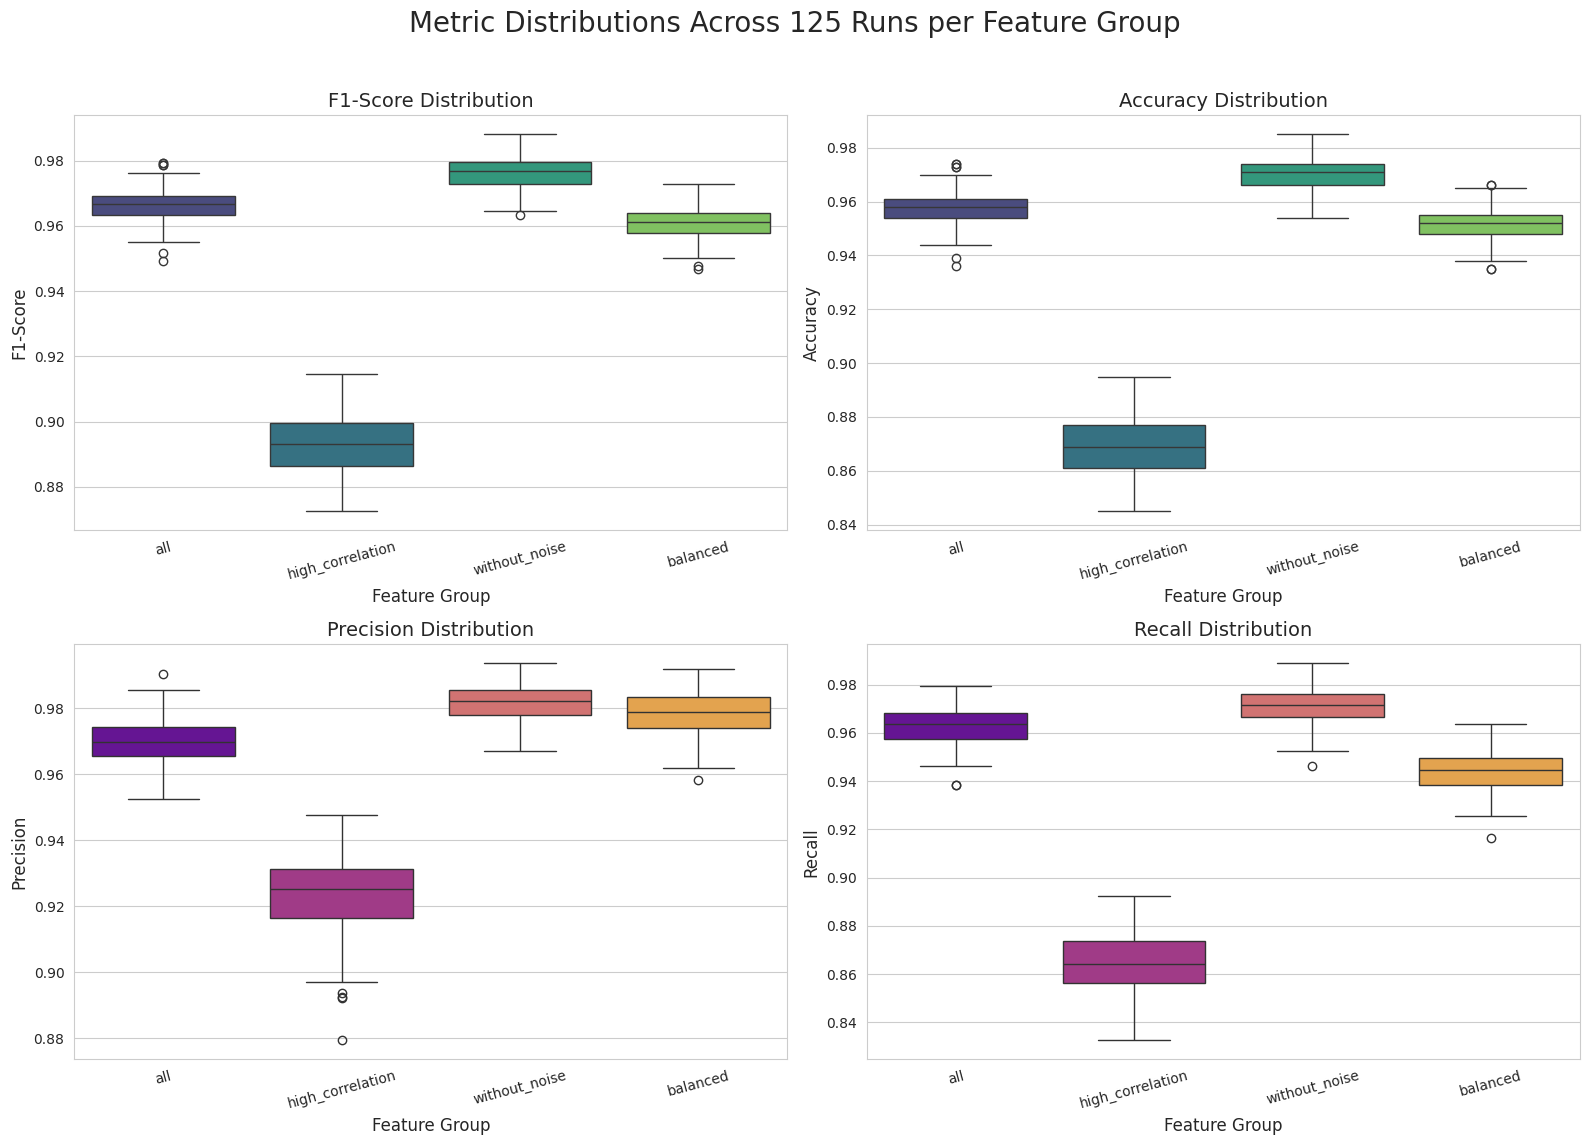

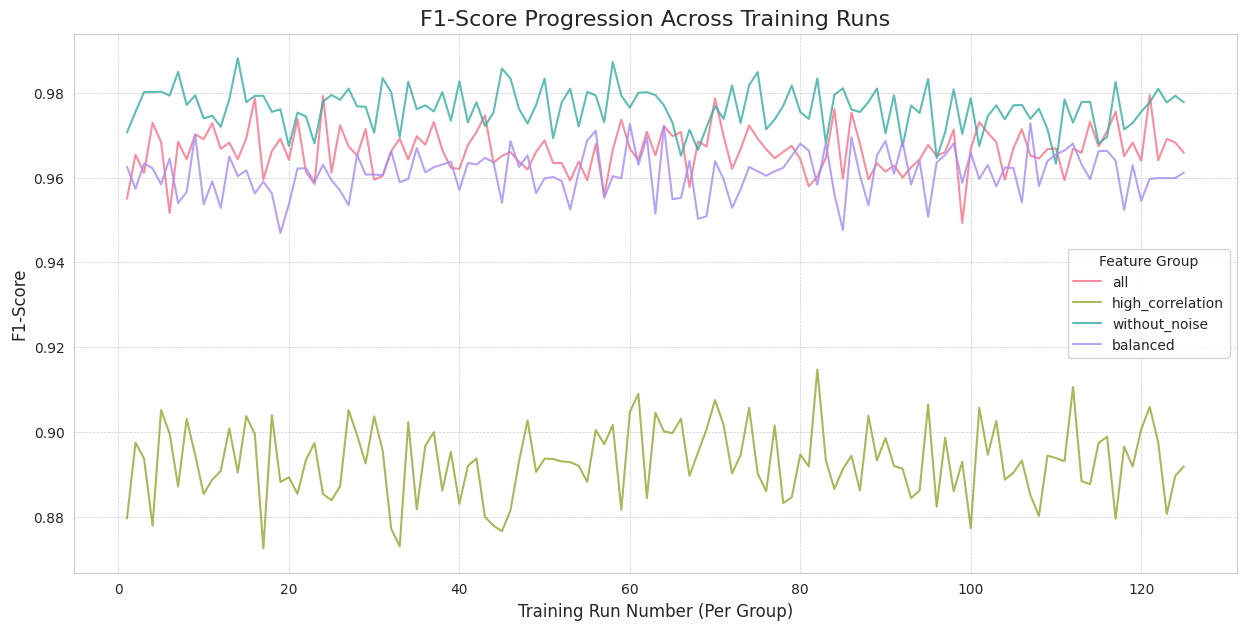



 ===
 RESULTS ANALYSIS: REPRODUCIBLE SPLIT MODE (FEATURE COMPARISON)
 ===

--- Summary F1-Score Statistics (Reproducible Mode) ---
                    mean     std     min     max
group                                           
without_noise     0.9761  0.0046  0.9631  0.9858
all               0.9653  0.0049  0.9522  0.9786
balanced          0.9613  0.0056  0.9427  0.9745
high_correlation  0.8924  0.0080  0.8705  0.9104


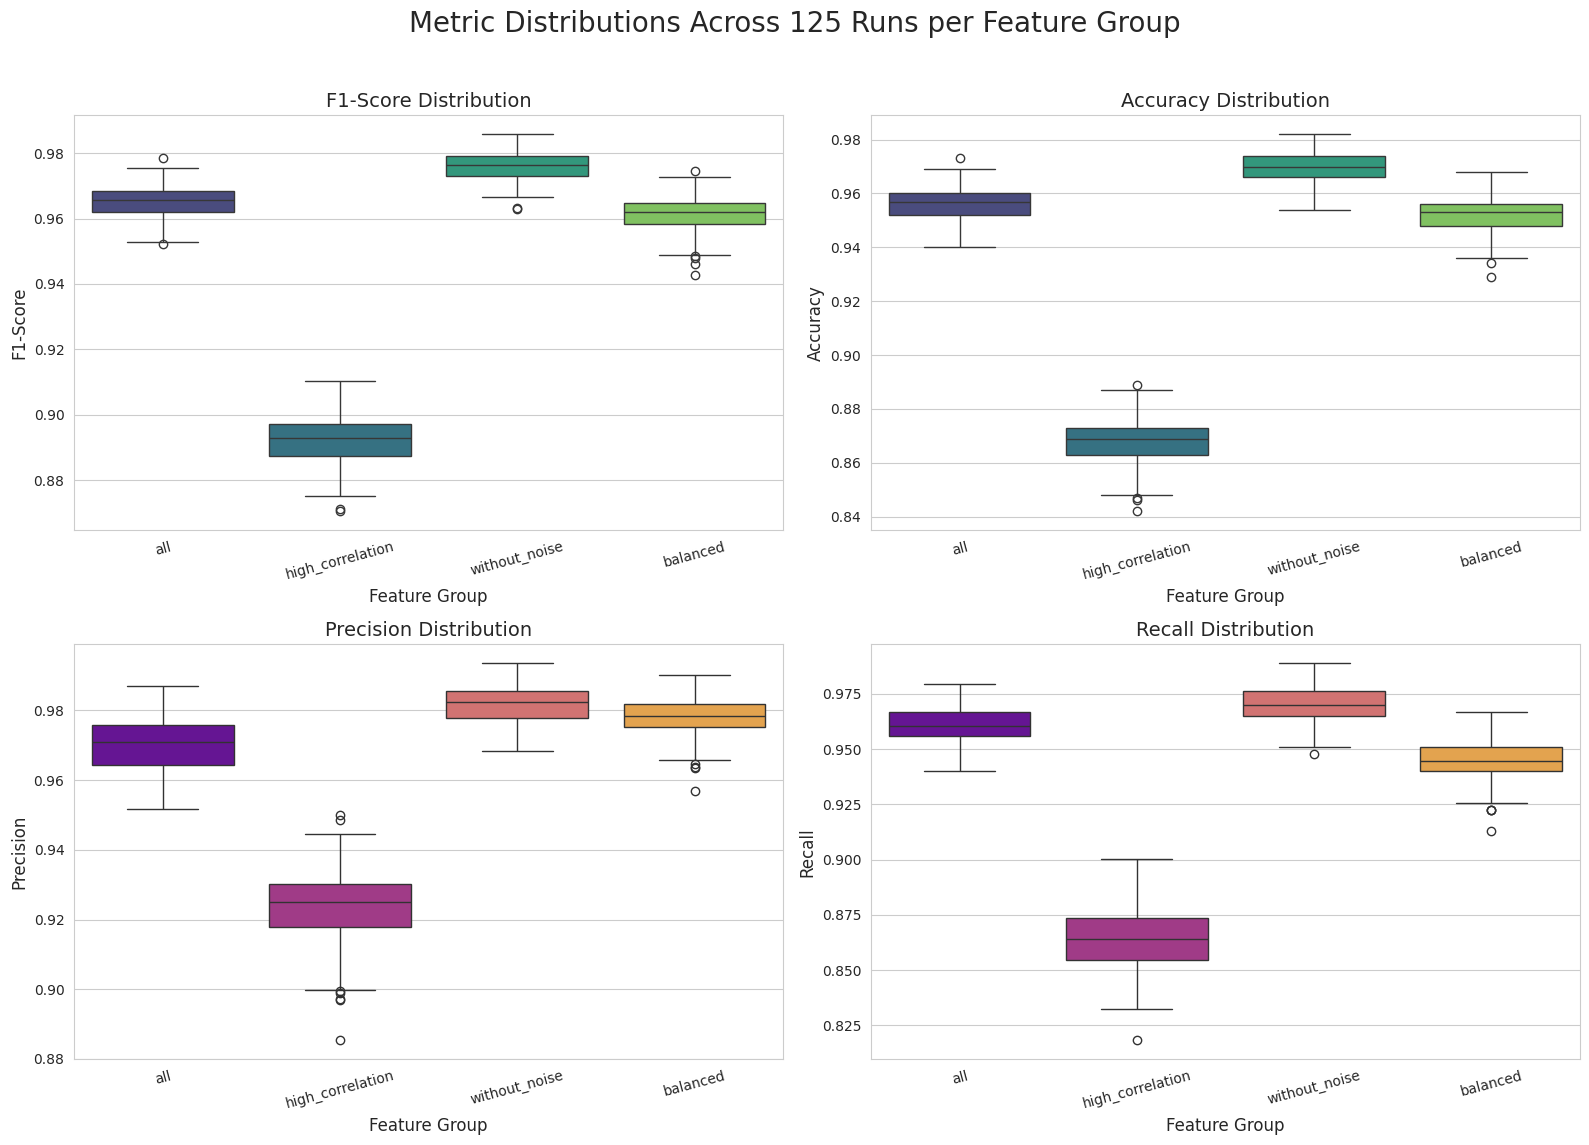

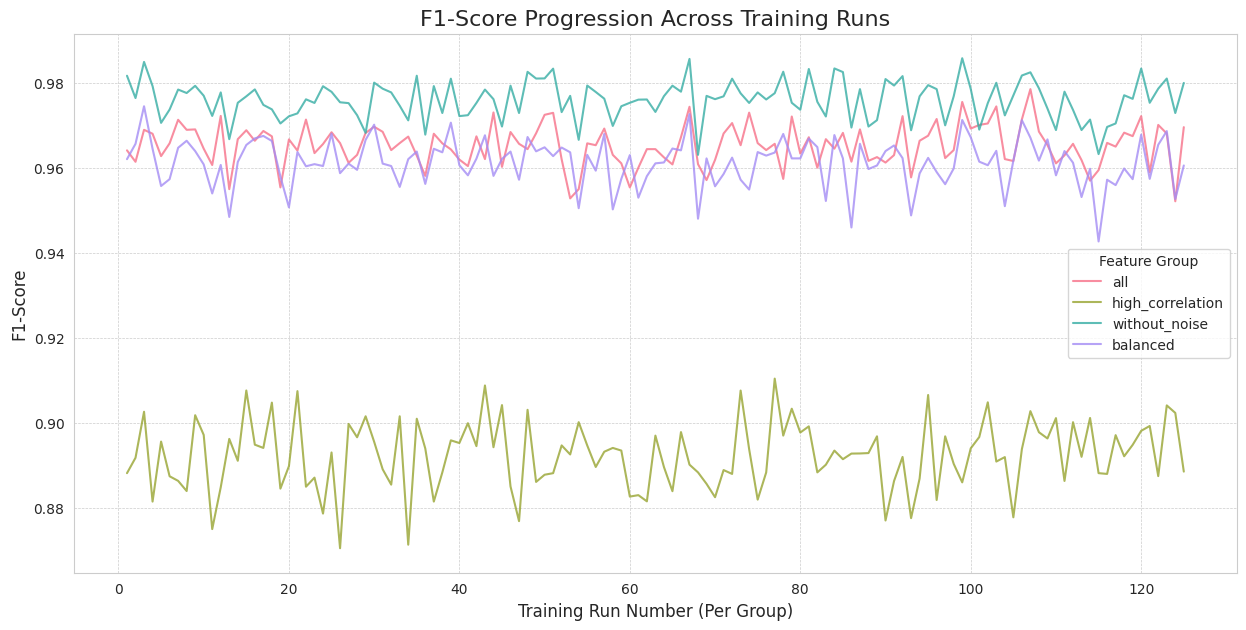



 ===
 REPRESENTATIVE MODEL VISUALIZATIONS (from Reproducible Mode)
 ===

--- Model for Group: 'all' ---


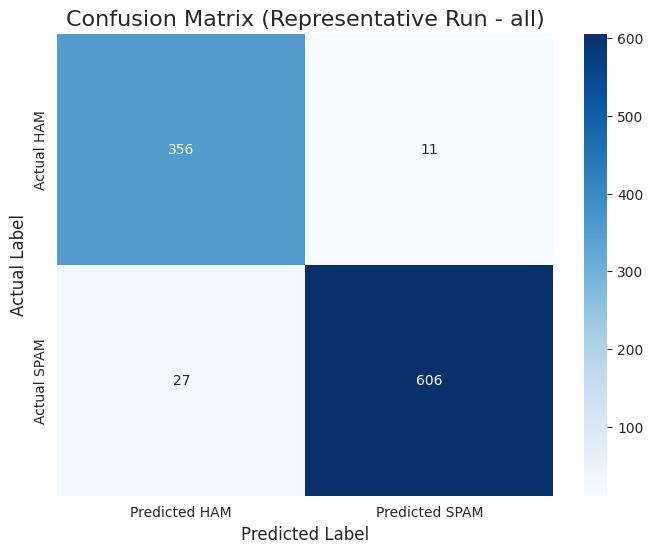

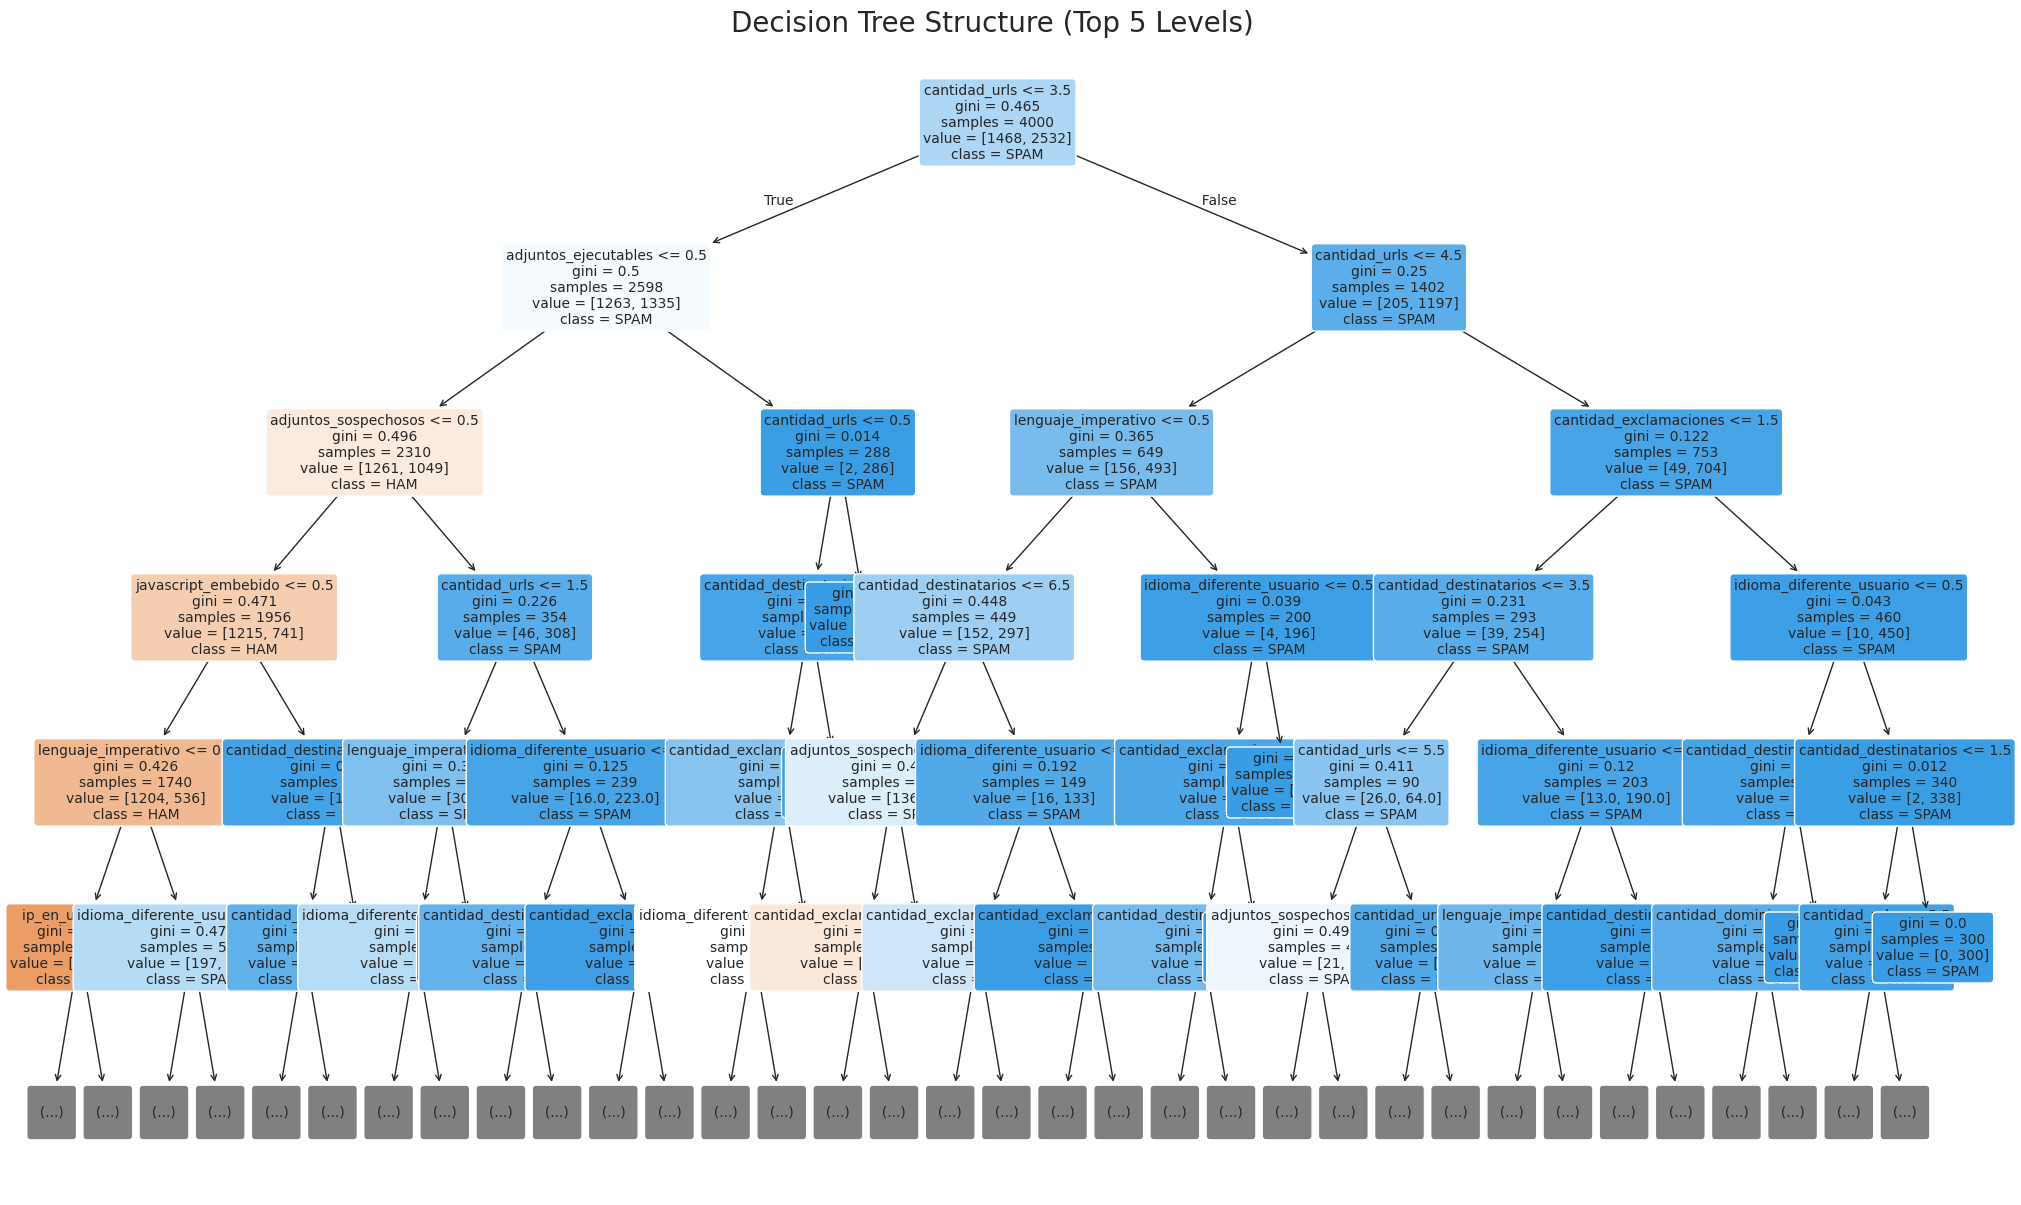


--- Model for Group: 'high_correlation' ---


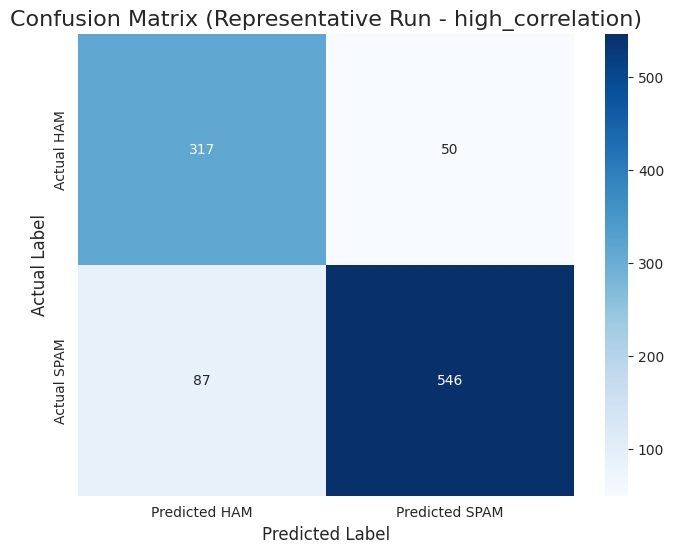

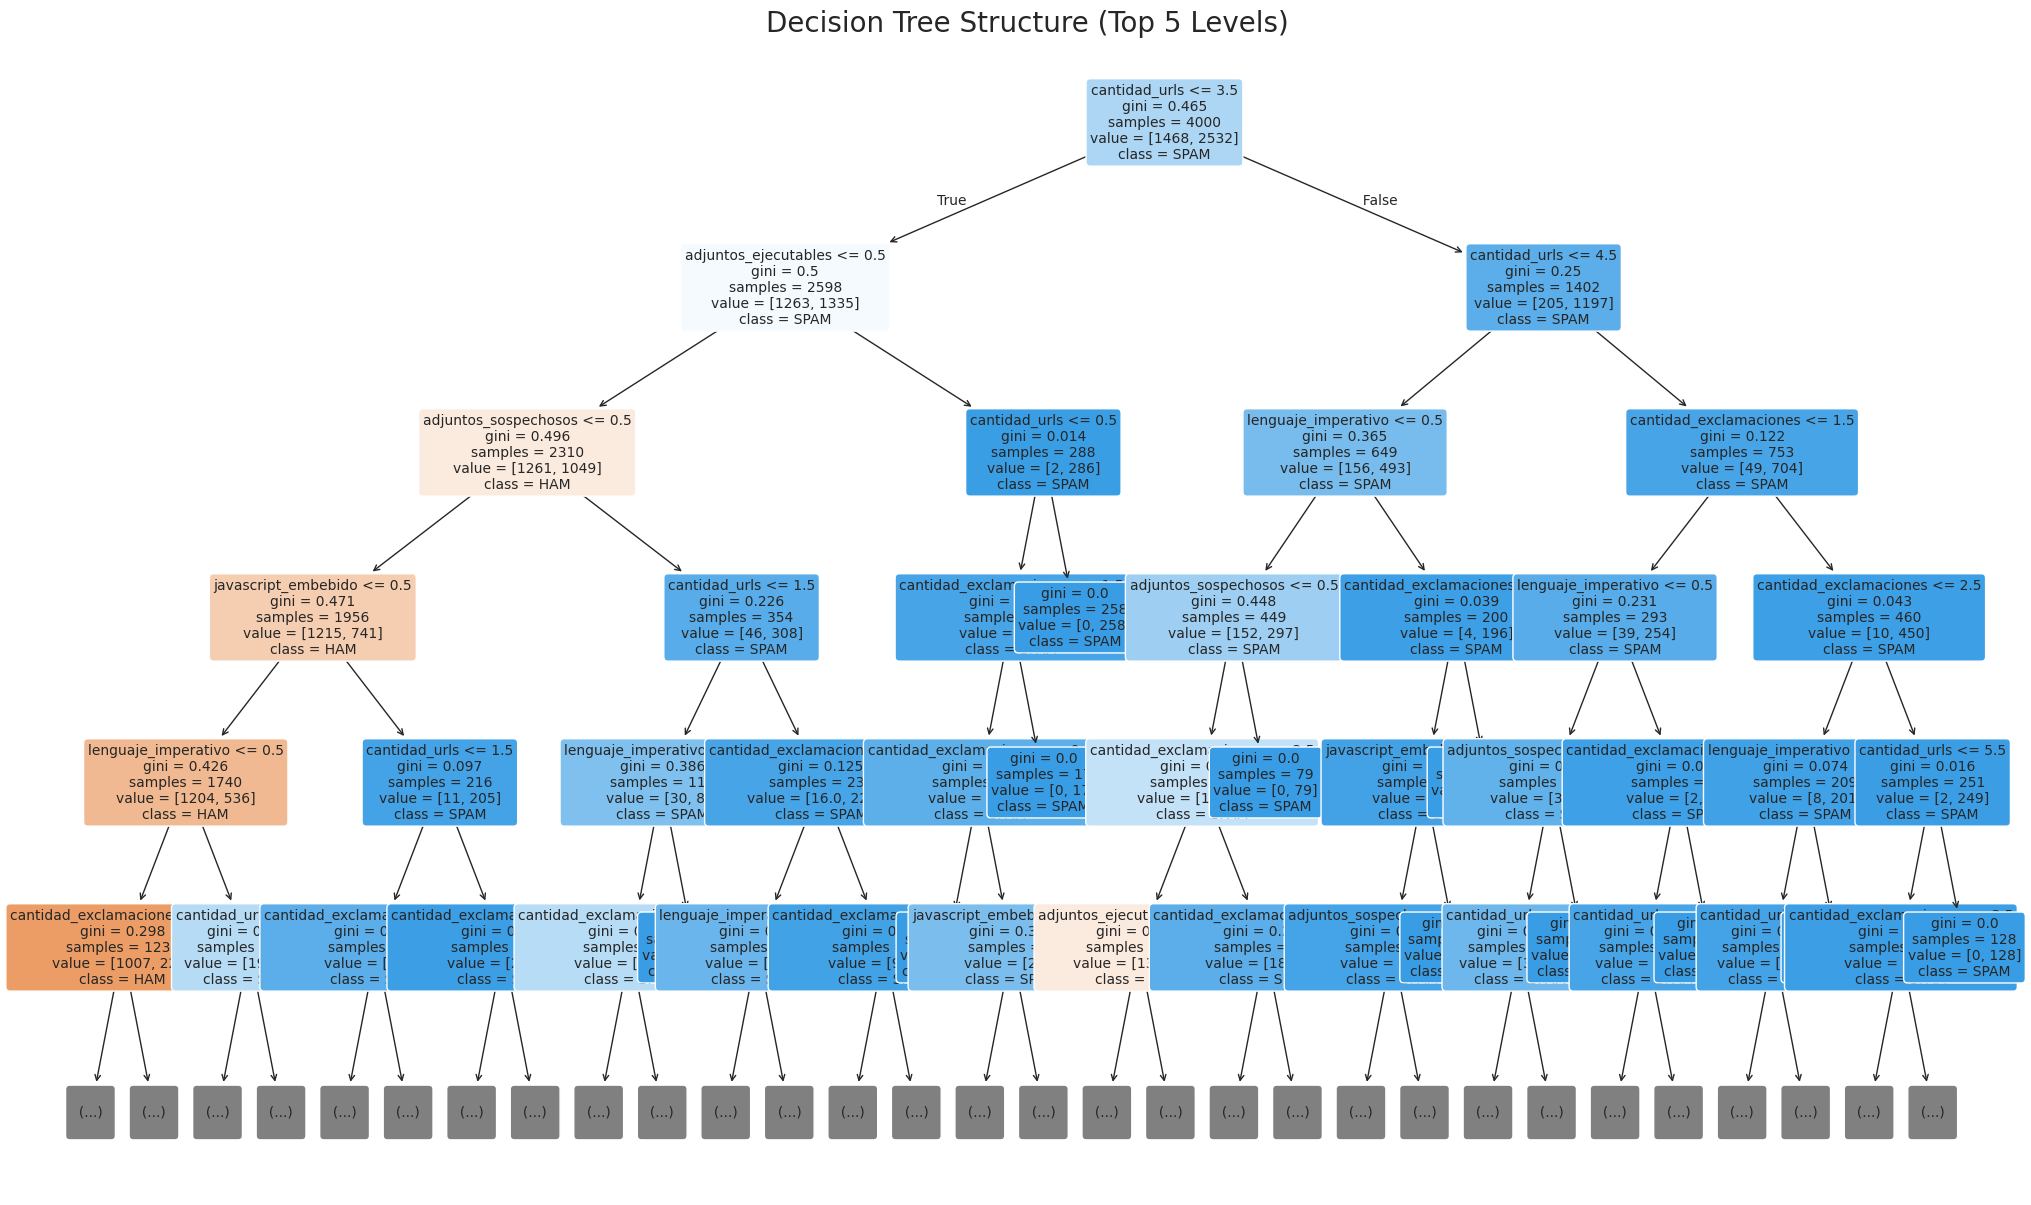


--- Model for Group: 'without_noise' ---


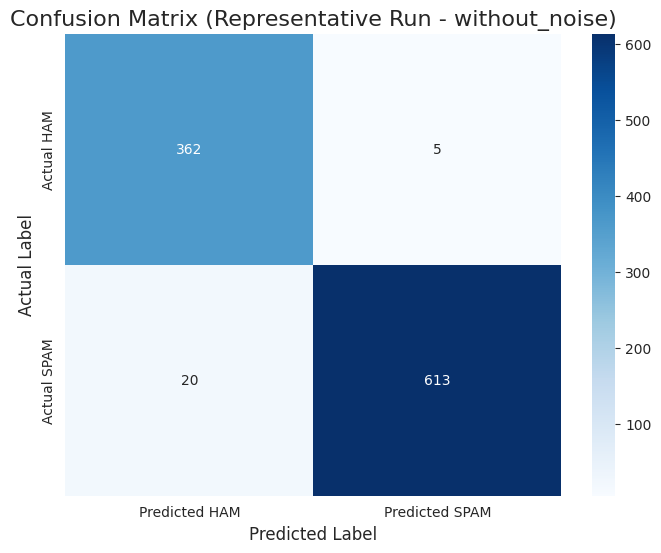

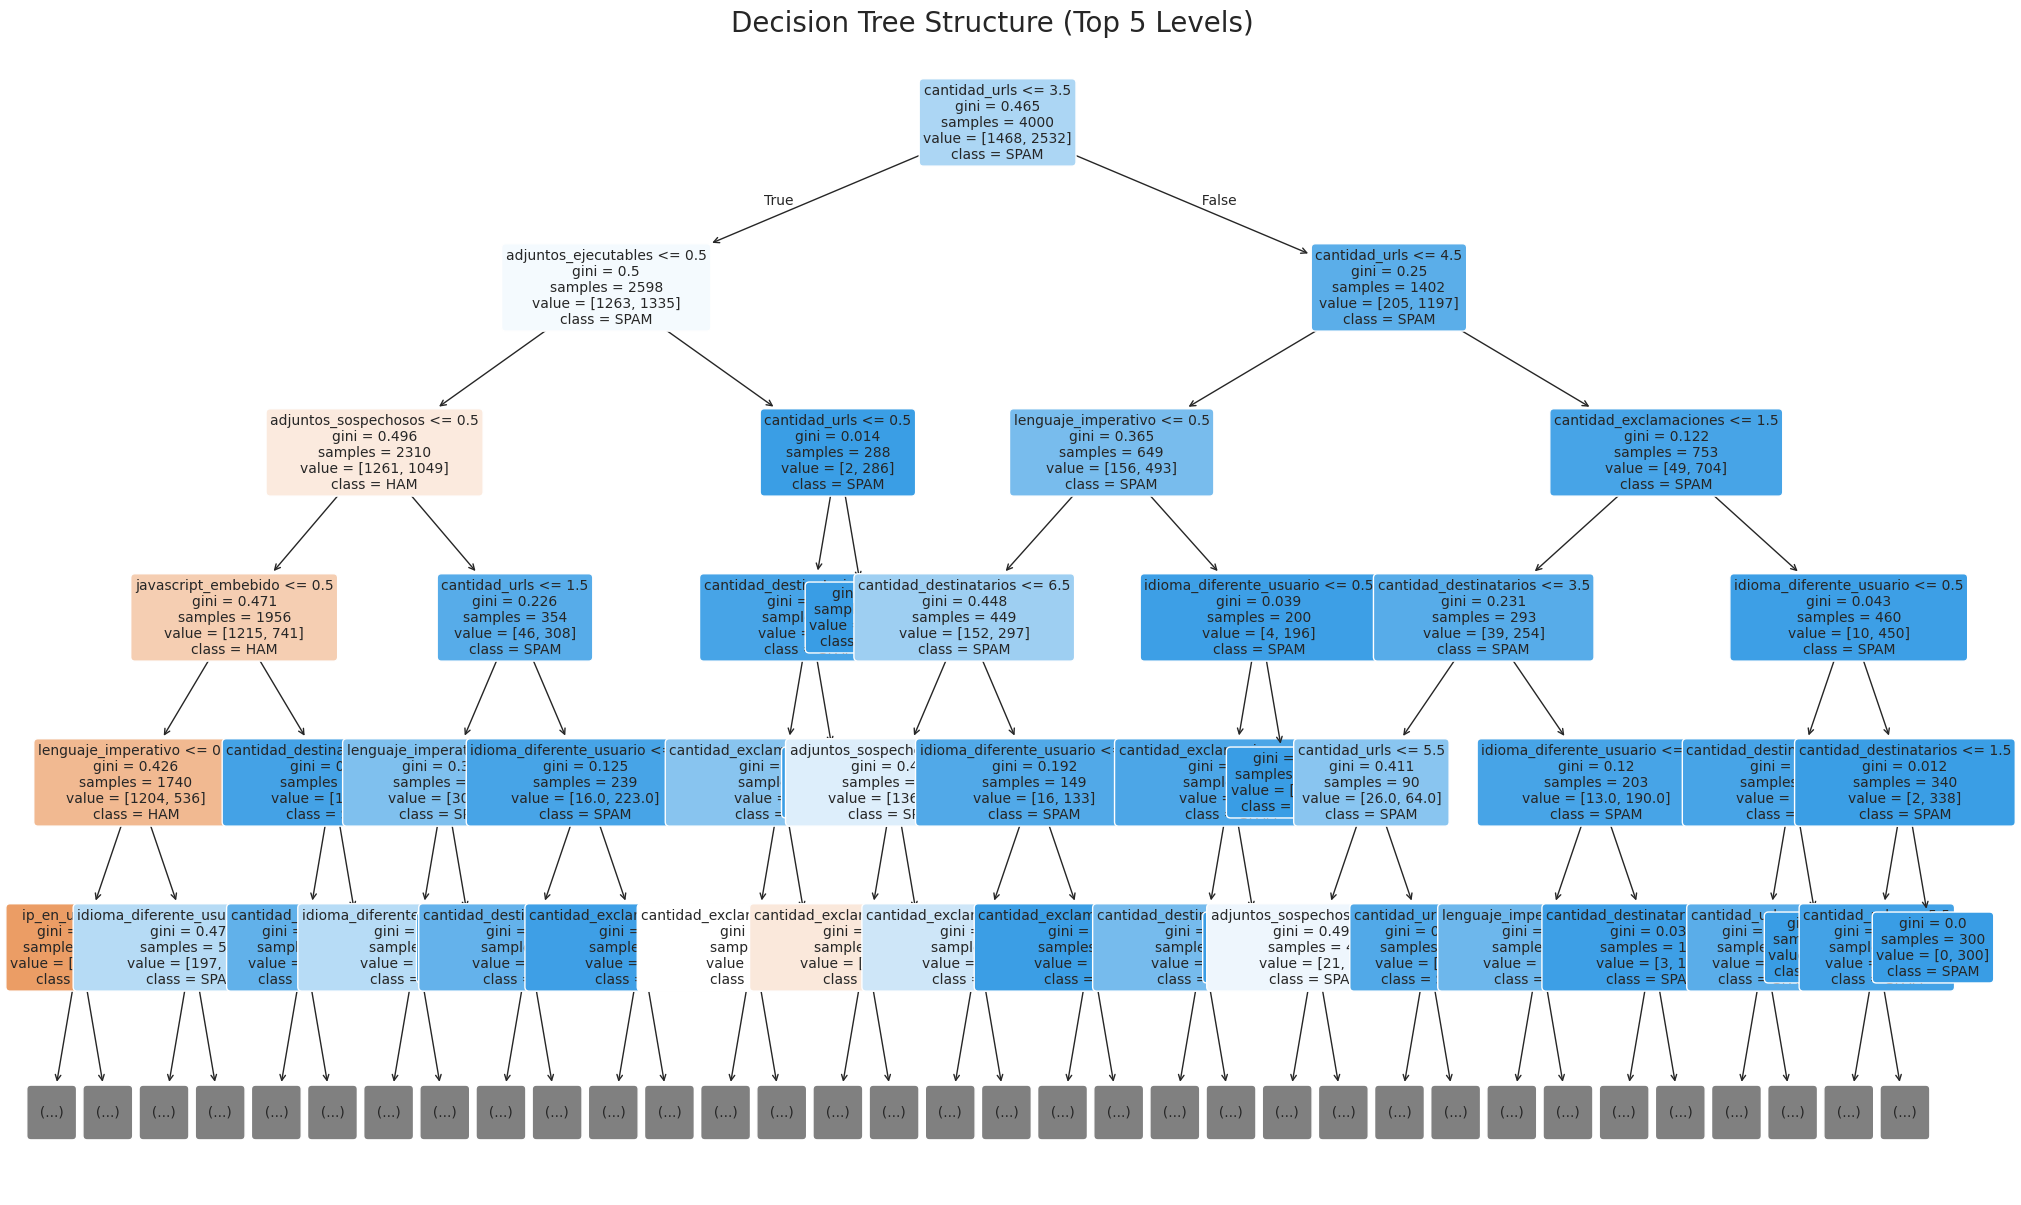


--- Model for Group: 'balanced' ---


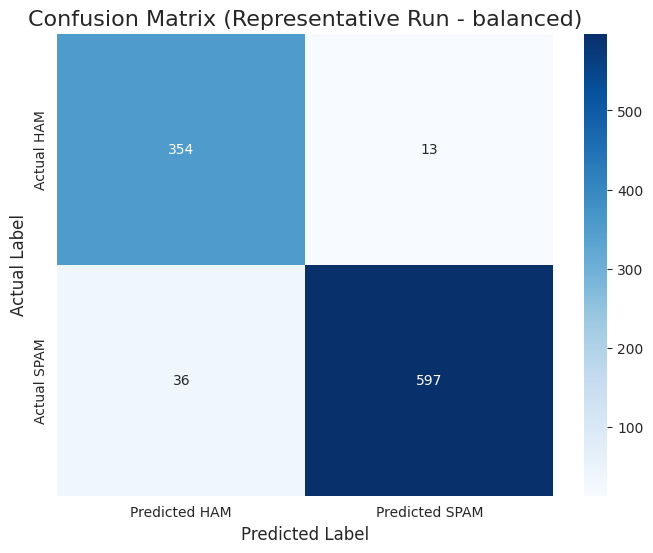

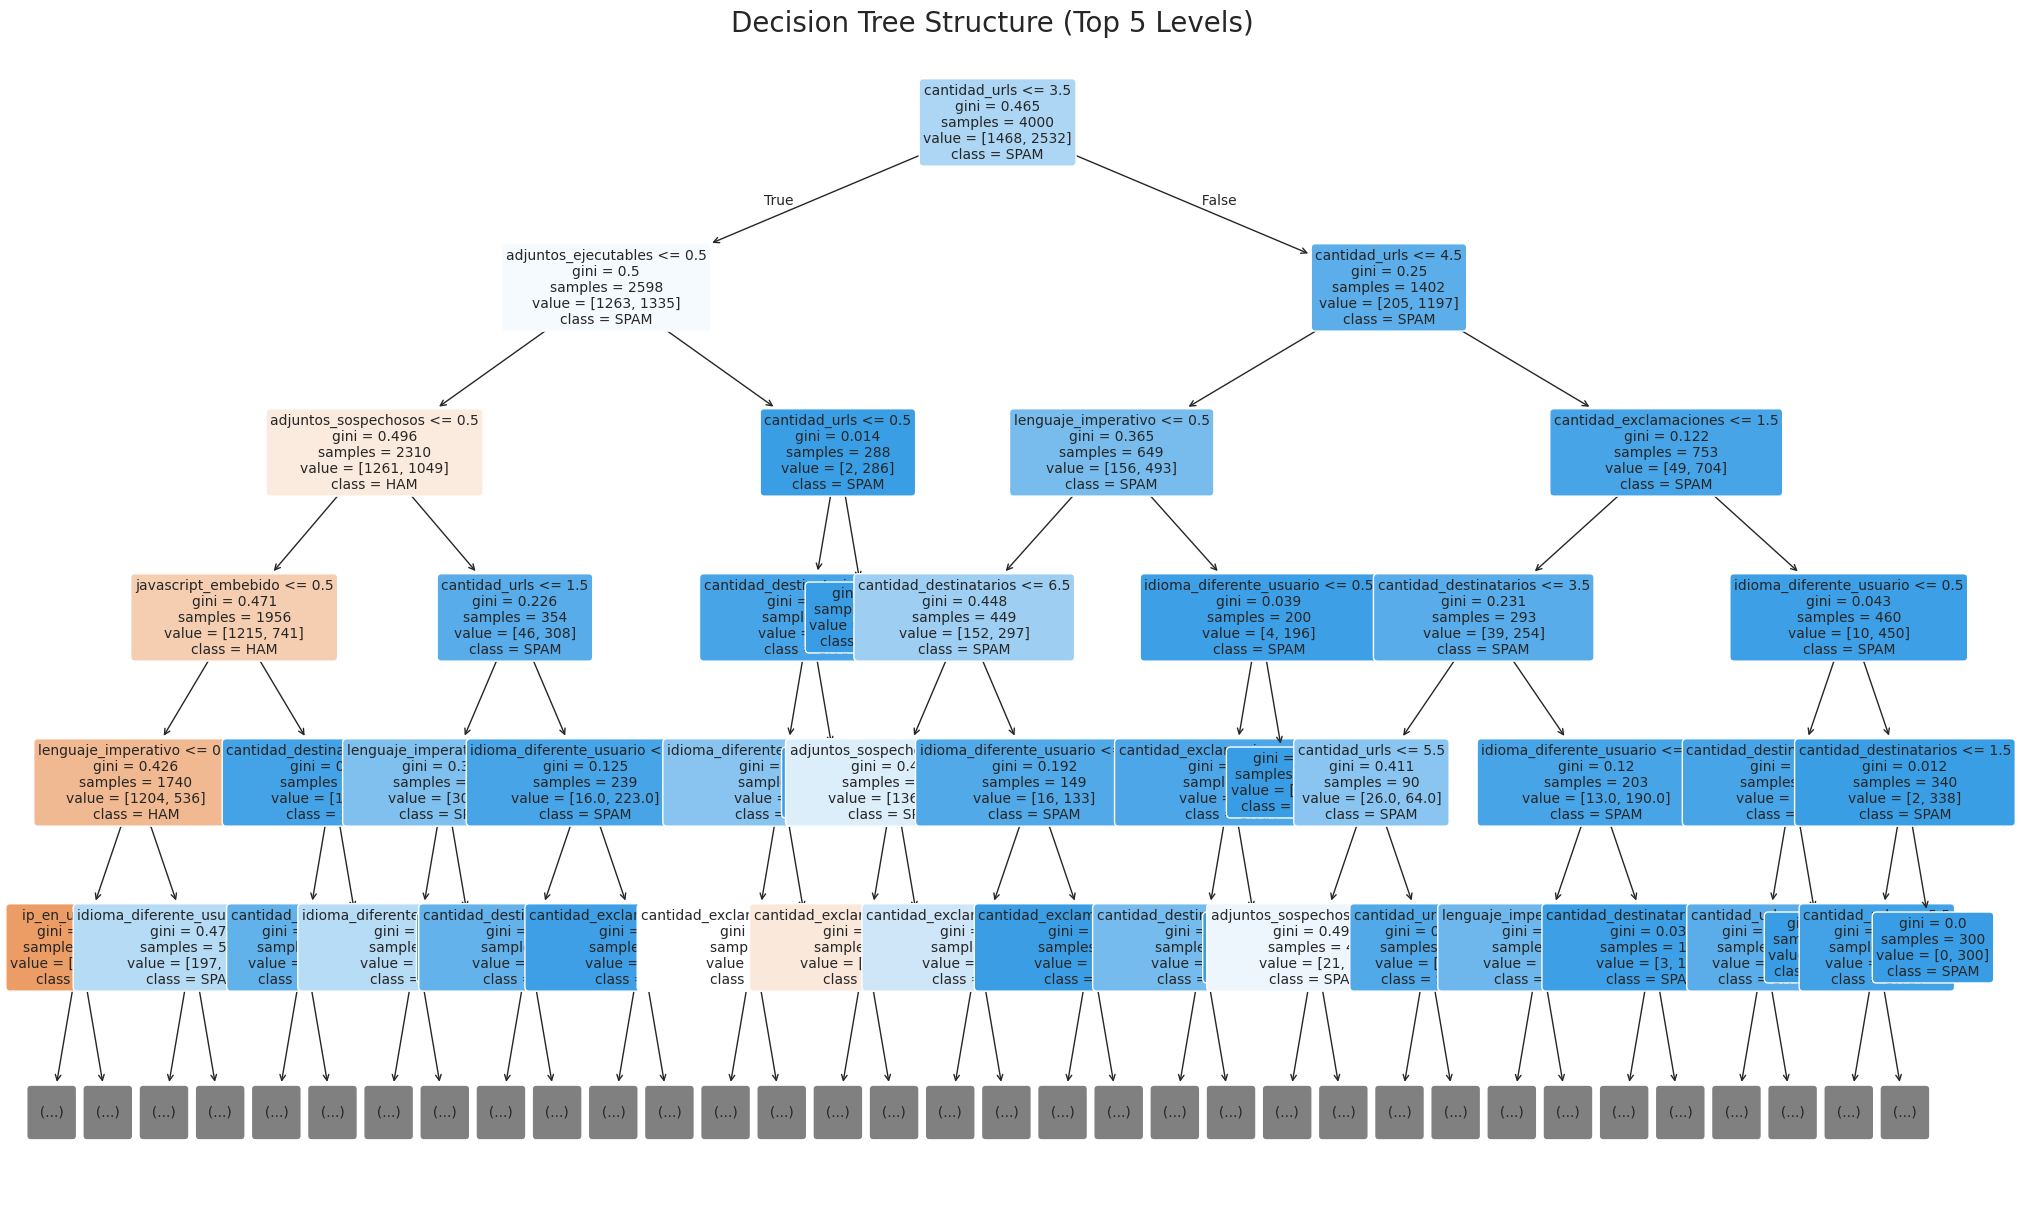

 ===
CROSS-VALIDATION RESULTS (STABILITY TEST)
 ===
              group   f1_mean    f1_std  accuracy_mean  accuracy_std
2     without_noise  0.976276  0.005052         0.9700      0.006481
0               all  0.963610  0.006533         0.9538      0.007859
3          balanced  0.960746  0.004374         0.9518      0.004956
1  high_correlation  0.892144  0.003978         0.8678      0.004665


In [ ]:
if __name__ == "__main__":
  main()